# Este notebook, tem como objetivo:
    * Analisar a distribuição dos dados utilizados no modelo de conhecimento utilizado no AQ30M
    * Verificar a possibilidade de utilizar uma amostra de nao_queimada.
    * Analisar a distribuição do indice de NDVI nos conjuntos de queimada e nao_queimada e por orb_pto.
    * Realizar a classificação de uma passagem utilizando diversos tipos de modelo de conhecimento.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import accuracy_score

/home/cicero/anaconda3/envs/aqml/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Exibindo gráficos no output do notebook
%matplotlib inline

In [3]:
# Escolhe o estilo para os gráficos com o seaborn
sns.set_style('whitegrid')

## Carrega dados

Neste CSV tem os dados históricos de 4 orb_pto, contendo apendas verifica 1 e 3:
    - 221_067
    - 221_070
    - 221_074
    - 226_070
**** Este dados, em algum momento foram revisados por alguem(autor desconhecido).

In [4]:
df = pd.read_csv('conhecimento.csv')
colunas = ['ndvi', 'nbrl', 'dif_ndvi', 'dif_dnbrl', 'medianb2', 'medianb3', 'medianb4', 'medianb5', 'medianb6', 'medianb7']

### Cria coluna ndvi_pre, nbrl_pre baseado no dado pos e dif

In [5]:
df['ndvi_pre'] = df['ndvi']+df['dif_ndvi']
df['nbrl_pre'] = df['nbrl']+df['dif_dnbrl']

### Visualização dos 2 primeiros dados

In [6]:
df.head(2)

,ndvi,nbrl,dif_ndvi,dif_dnbrl,medianb2,medianb3,medianb4,medianb5,medianb6,medianb7,id_cena,id,verifica,orb_pto,ndvi_pre,nbrl_pre
0,0.188449,0.099966,0.357634,0.358997,0.264355,0.271096,0.282550,0.416970,0.437964,0.338563,LS82260702016206,104895,3,226_070,0.546083,0.458963
1,0.187517,0.078289,0.352527,0.348624,0.283693,0.287363,0.301245,0.438293,0.450804,0.370669,LS82260702016206,104843,3,226_070,0.540045,0.426913


## Separa em 2 sub-conjuntos(queimadas e nao_queimadas)
    * Foi alterado o label de verifica para textual, facilitando o uso de alguns gráficos do seaborn que confunde o dado inteiro como feature e não como metadado

In [7]:
df['verifica'] = df.verifica.apply(lambda x: 'queimada' if x == 1 else 'nao_queimada')
df1 = df[df.verifica=='queimada'] # queimada
df3 = df[df.verifica=='nao_queimada'] # nao queimada
df_full = pd.concat([df1,df3])

## Verificando a possibilidade de trabalhar com uma amostra e não a população de NAO_QUEIMADA
    * Esta tentativa esta sendo testa devido ao fato de existir um grande número dado de nao_queimada.
    * O script abaixo esta criando uma variável df3_amostra, que tem uma amostra aleatória de nao_queimada, com a mesma quantidade do conjunto de queimada

# Lista todas cenas de uma orb_pto de um determinado ano
Neste exemplo, esta sendo filtrado os ID_CENAs da orb_pto 221_074 do ano de 2017

# * Apartir deste ponto, os dados observados serão somentes desta orb_pto/ano

In [8]:
orb_pto = '221_074'
df_orb_pto = df[df.id_cena.str.contains('%s2017' % orb_pto.replace('_', ''))]
id_cenas = sorted(df_orb_pto.id_cena.unique())
id_cenas

['LS82210742017045',
 'LS82210742017093',
 'LS82210742017109',
 'LS82210742017157',
 'LS82210742017173',
 'LS82210742017205',
 'LS82210742017221',
 'LS82210742017237',
 'LS82210742017253',
 'LS82210742017269',
 'LS82210742017285',
 'LS82210742017317',
 'LS82210742017333']

## Histograma NDVI e NBRL de cada passagem

    * Esta sendo plotado, a curva de densidade de queimada e nao_queimada
    * A amostra de nao_queimada não esta sendo gerada. Nesta orb_pto, o conjunto de queimada é maior que nao_queimada

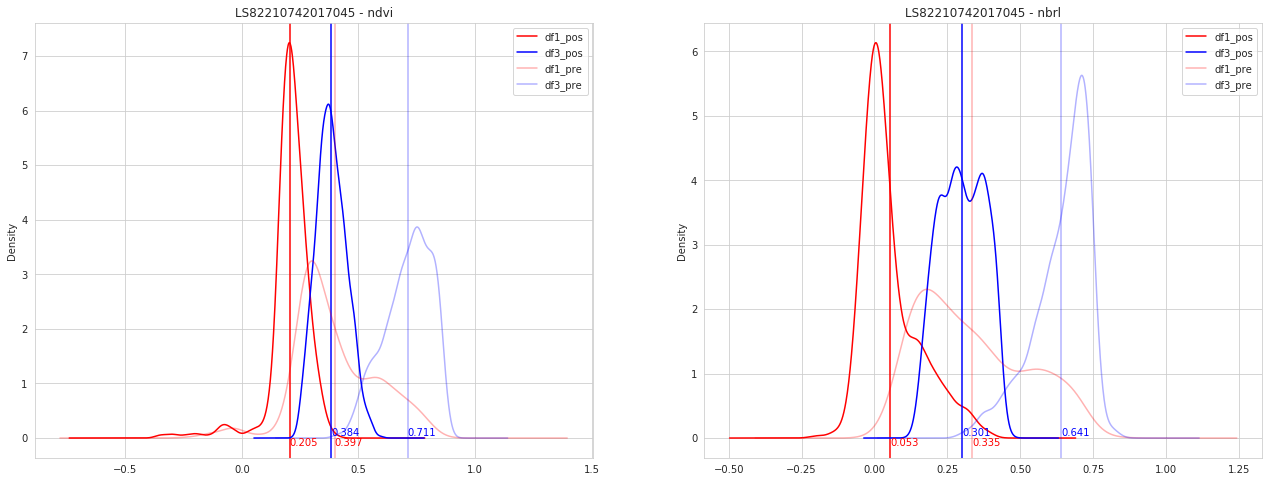

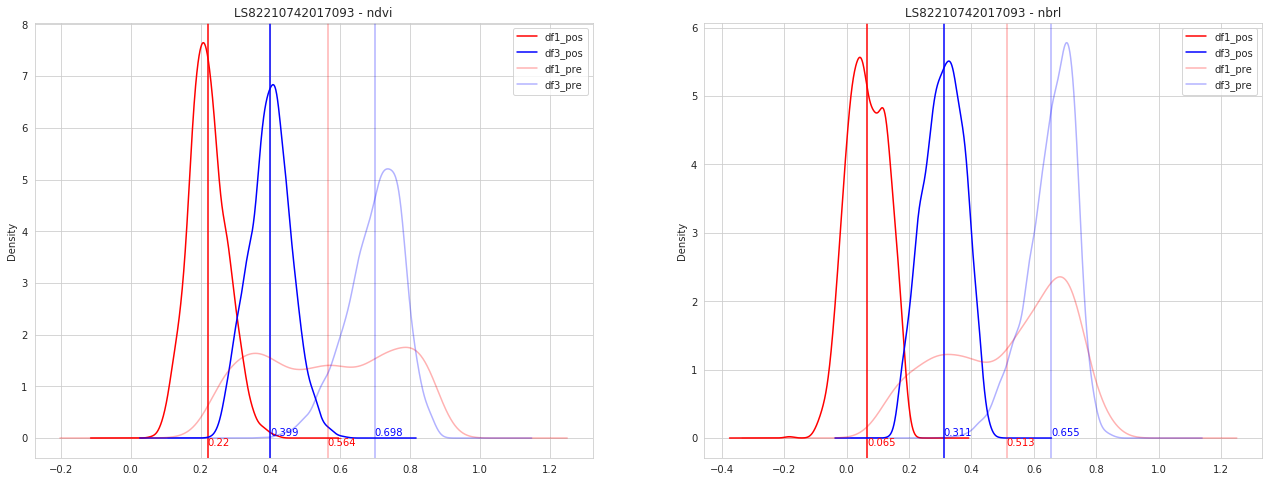

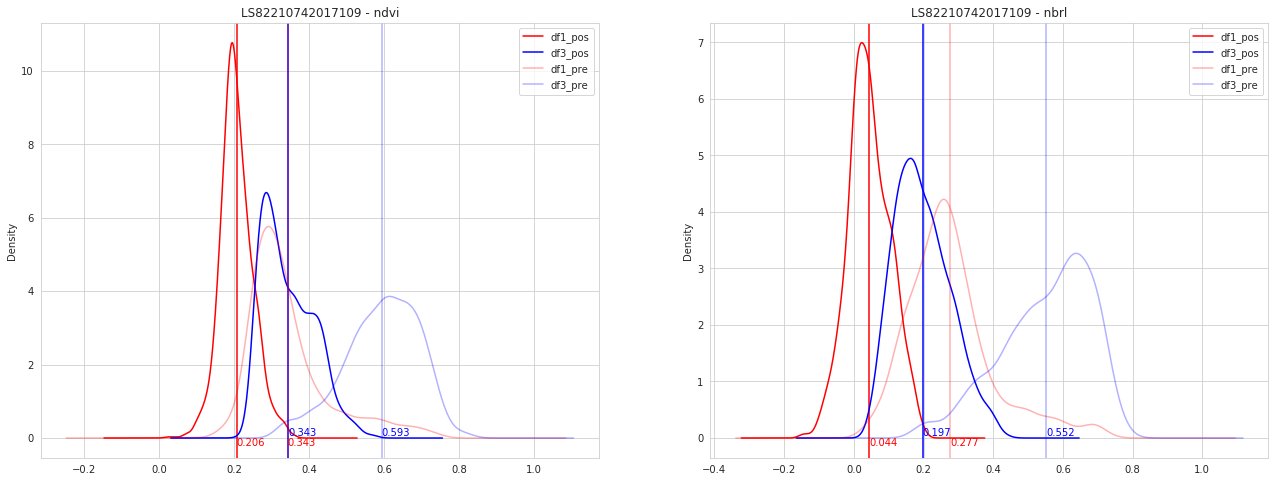

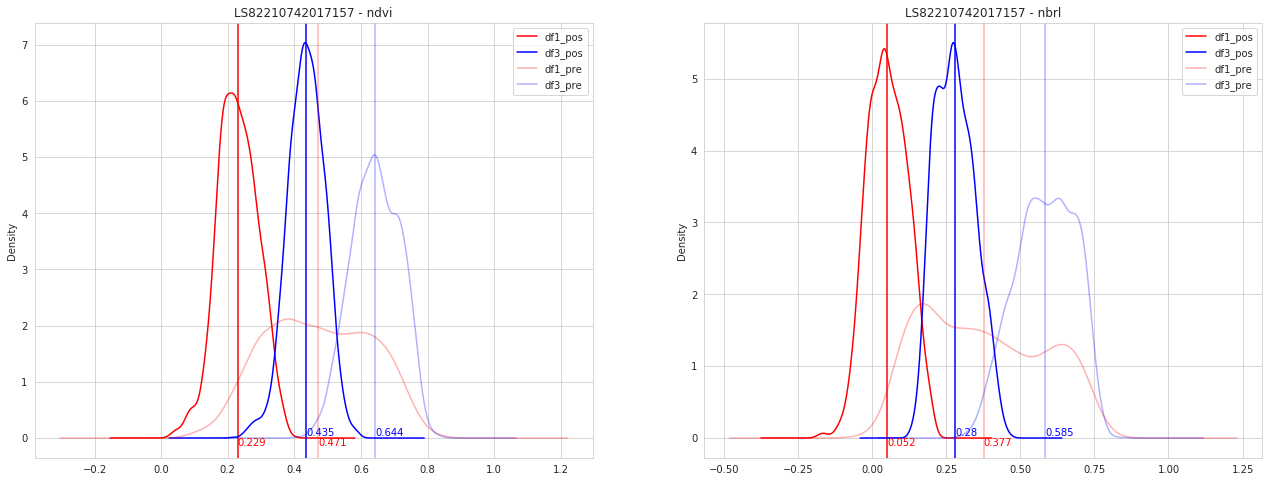

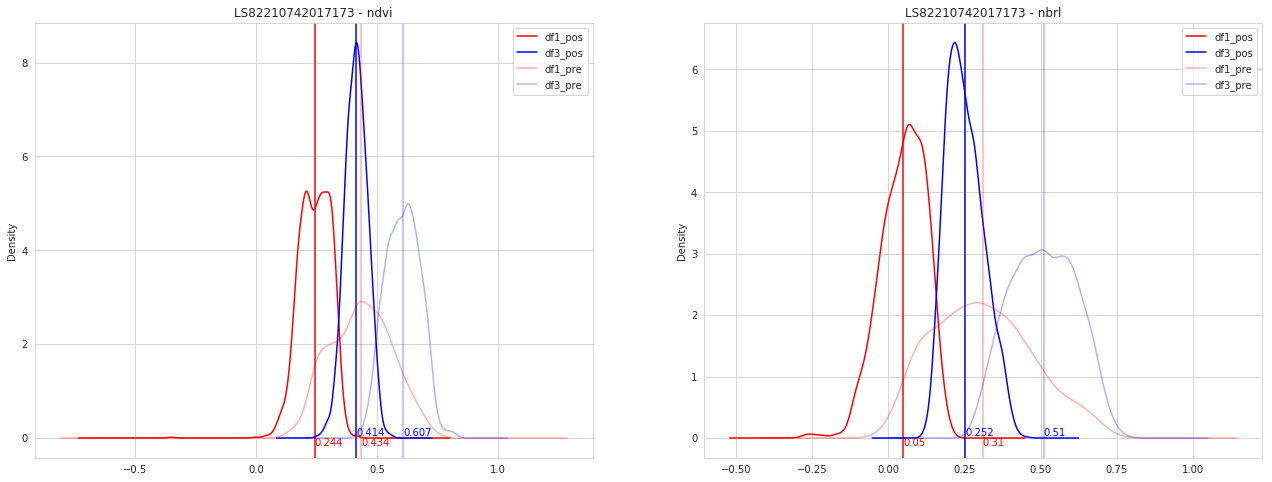

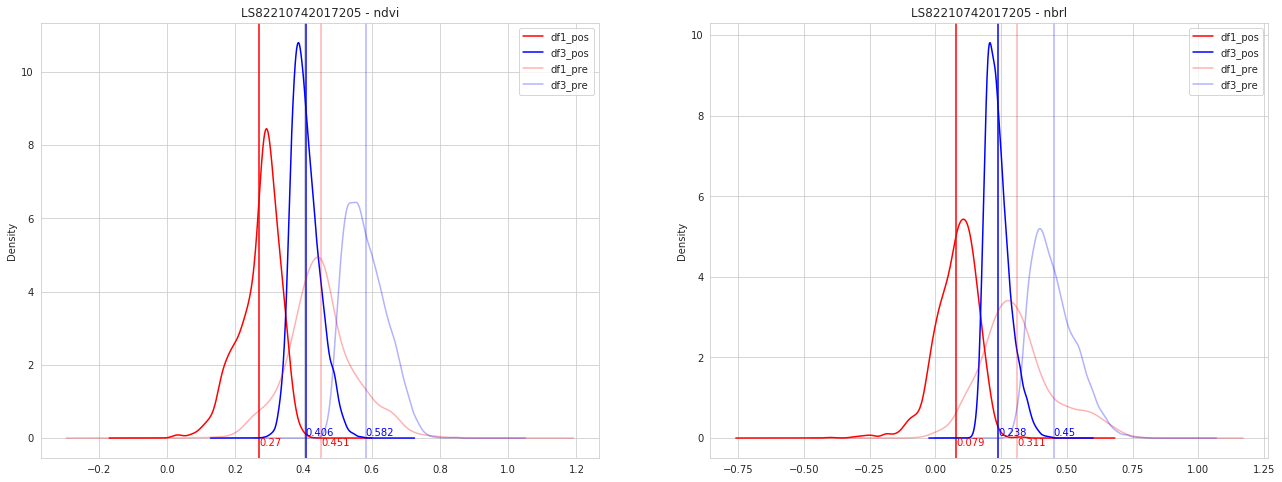

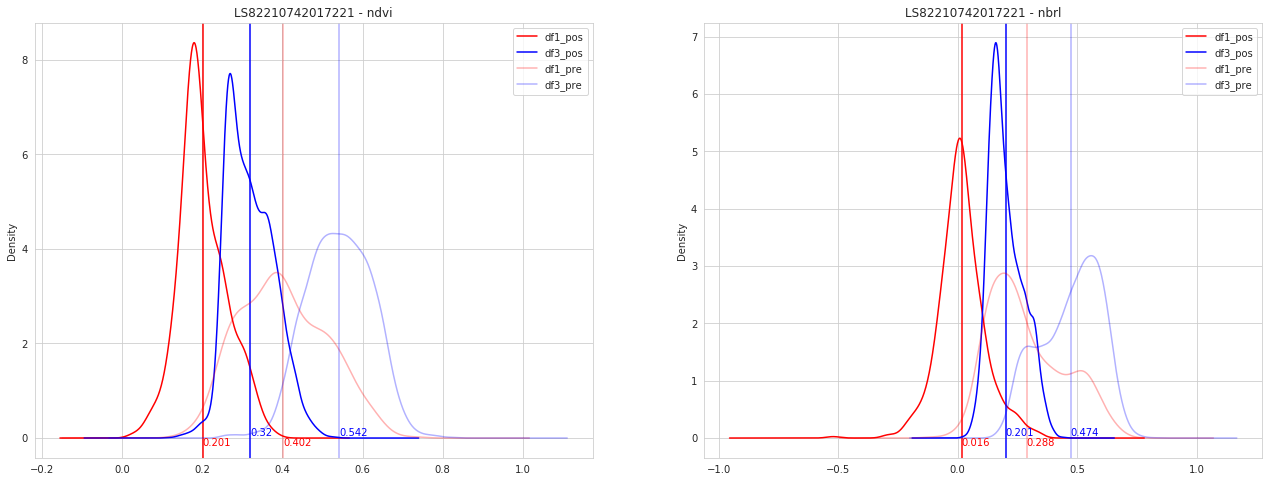

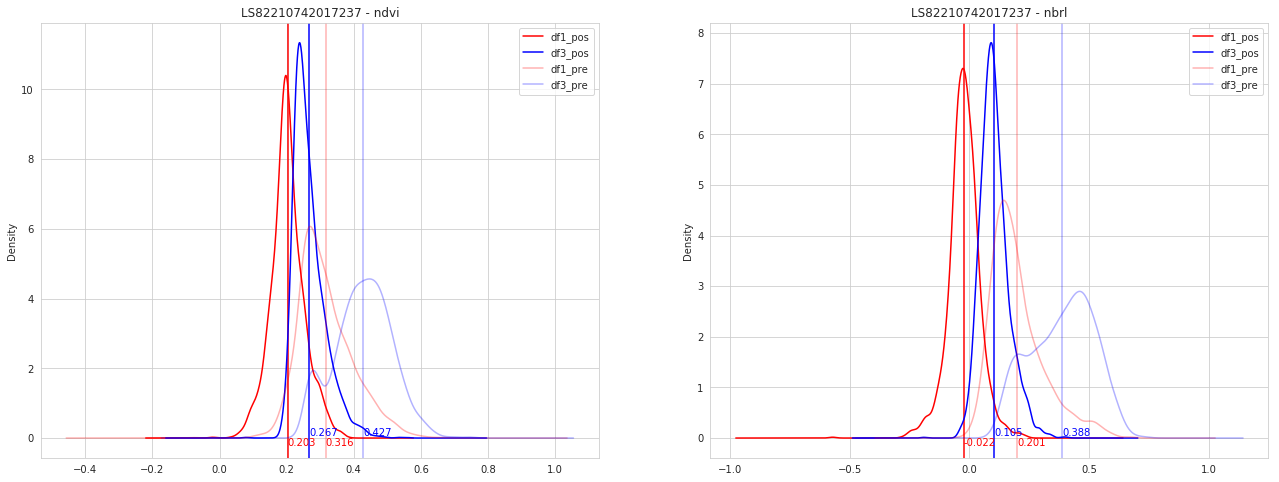

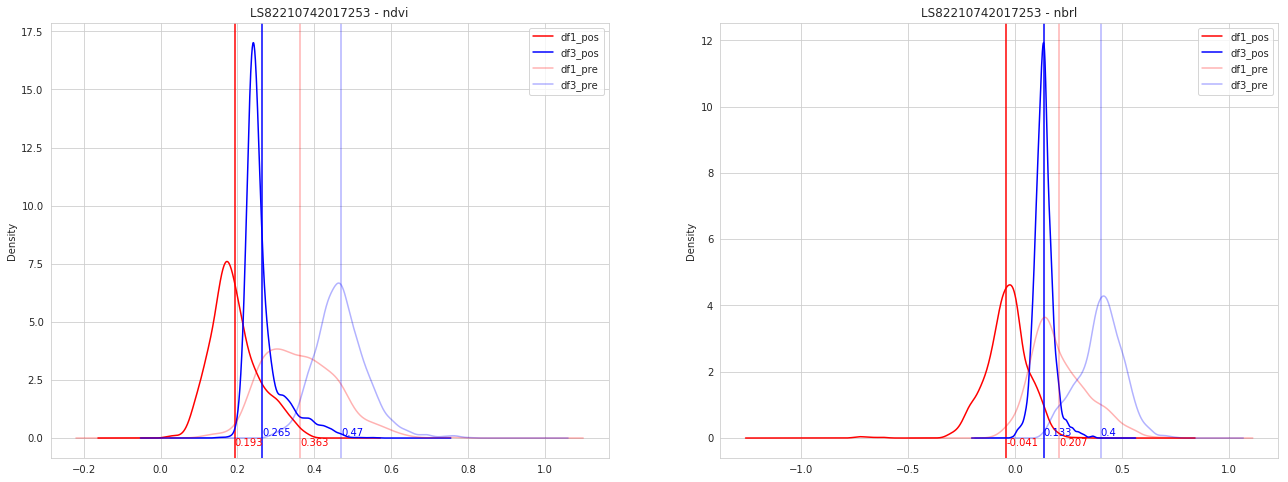

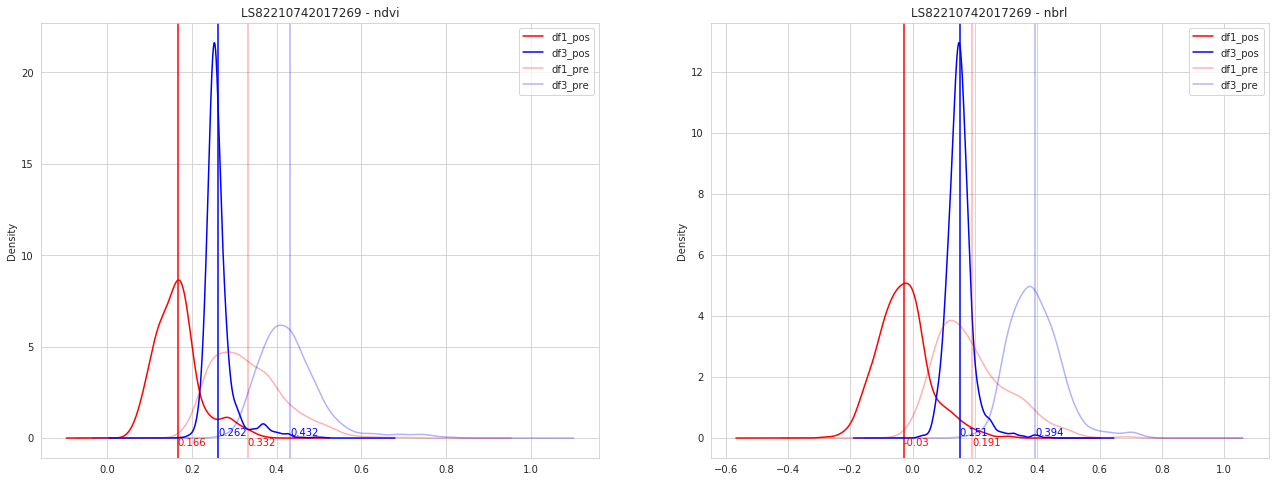

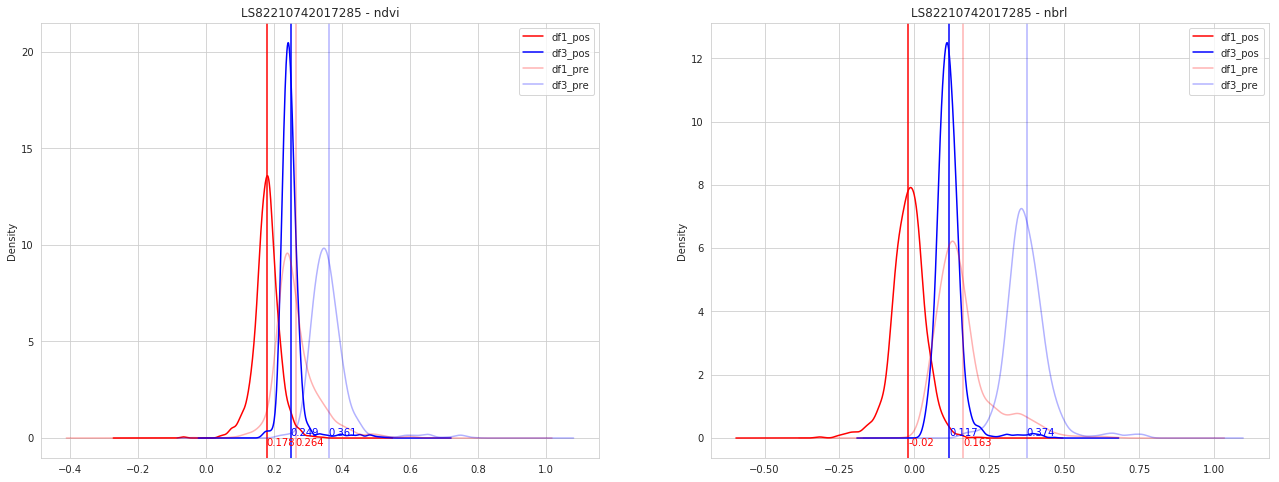

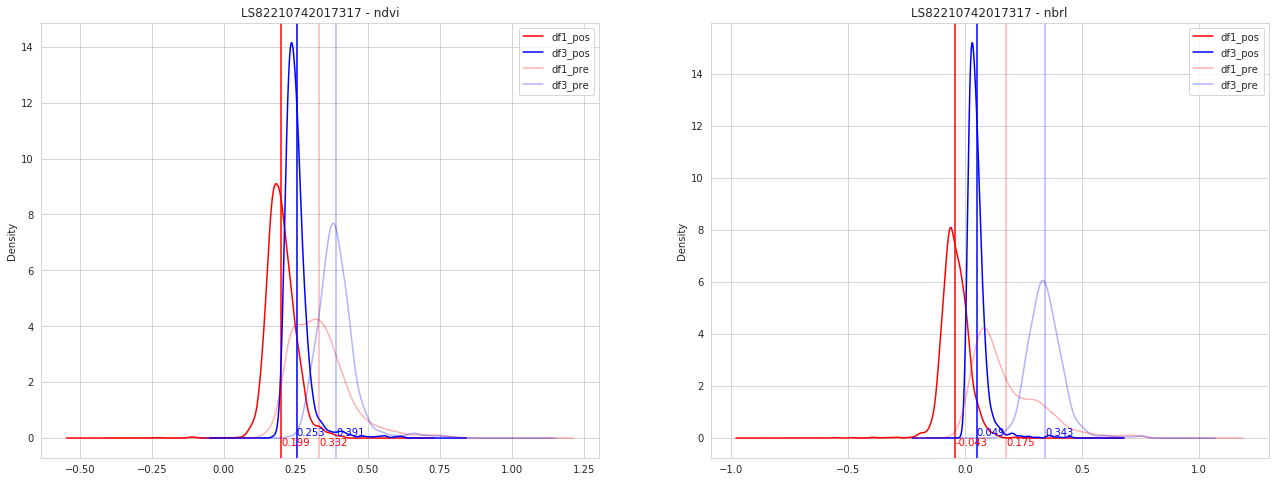

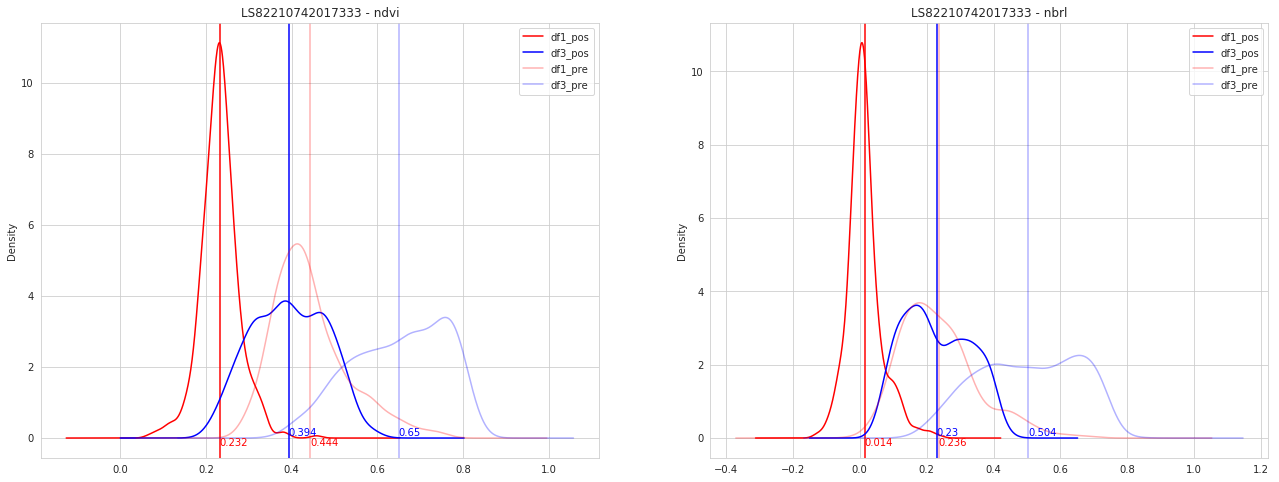

In [9]:
for i in id_cenas:
    fig, ax = plt.subplots(figsize=(22,8))
    d = df[df.id_cena==i].copy()
    d1 = d[d.verifica=='queimada']
    d3 = d[d.verifica=='nao_queimada']
    
    if not len(d1):
        print('Data sem dado de queimada', i)
        continue
    if not len(d3):
        print('Data sem dado de nao_queimada', i)
        continue
    
    col = 'ndvi'
    plt.subplot(1, 2, 1)
    plt.title('%s - %s' % (i, col))
    ax = d1[col].plot.kde(c='r', label='df1_pos')
    plt.axvline(d1[col].mean(), c='r')
    ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')
    
    d3[col].plot.kde(c='b', label='df3_pos')
    plt.axvline(d3[col].mean(), c='b')
    ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
        
    col = 'ndvi_pre'
    d1[col].plot.kde(c='r', label='df1_pre', alpha=0.3)
    plt.axvline(d1[col].mean(), c='r', alpha=0.3)
    ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')
    
    d3[col].plot.kde(c='b', label='df3_pre', alpha=0.3)
    plt.axvline(d3[col].mean(), c='b', alpha=0.3)
    ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
    plt.legend()
    
    col = 'nbrl'
    plt.subplot(1, 2, 2)
    plt.title('%s - %s' % (i, col))
    ax = d1[col].plot.kde(c='r', label='df1_pos')
    plt.axvline(d1[col].mean(), c='r')
    ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')
    
    d3[col].plot.kde(c='b', label='df3_pos')
    plt.axvline(d3[col].mean(), c='b')
    ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
    
    col = 'nbrl_pre'
    d1[col].plot.kde(c='r', label='df1_pre', alpha=0.3)
    plt.axvline(d1[col].mean(), c='r', alpha=0.3)
    ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')
    
    d3[col].plot.kde(c='b', label='df3_pre', alpha=0.3)
    plt.axvline(d3[col].mean(), c='b', alpha=0.3)
    ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
    plt.legend()

In [10]:
paleta_cores = {'queimada': 'red', 'nao_queimada': 'blue'}

# Correlação

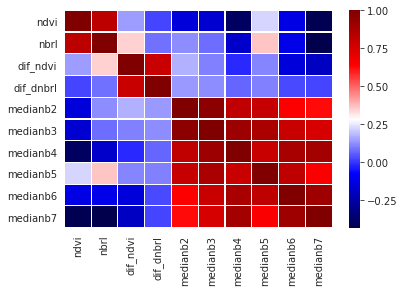

In [11]:
correlacao = df_orb_pto[colunas].corr()
sns.heatmap(correlacao, cmap='seismic', linecolor='white', linewidths=0.1)

# Graficos cruzando as combinações de colunas e suas correlações

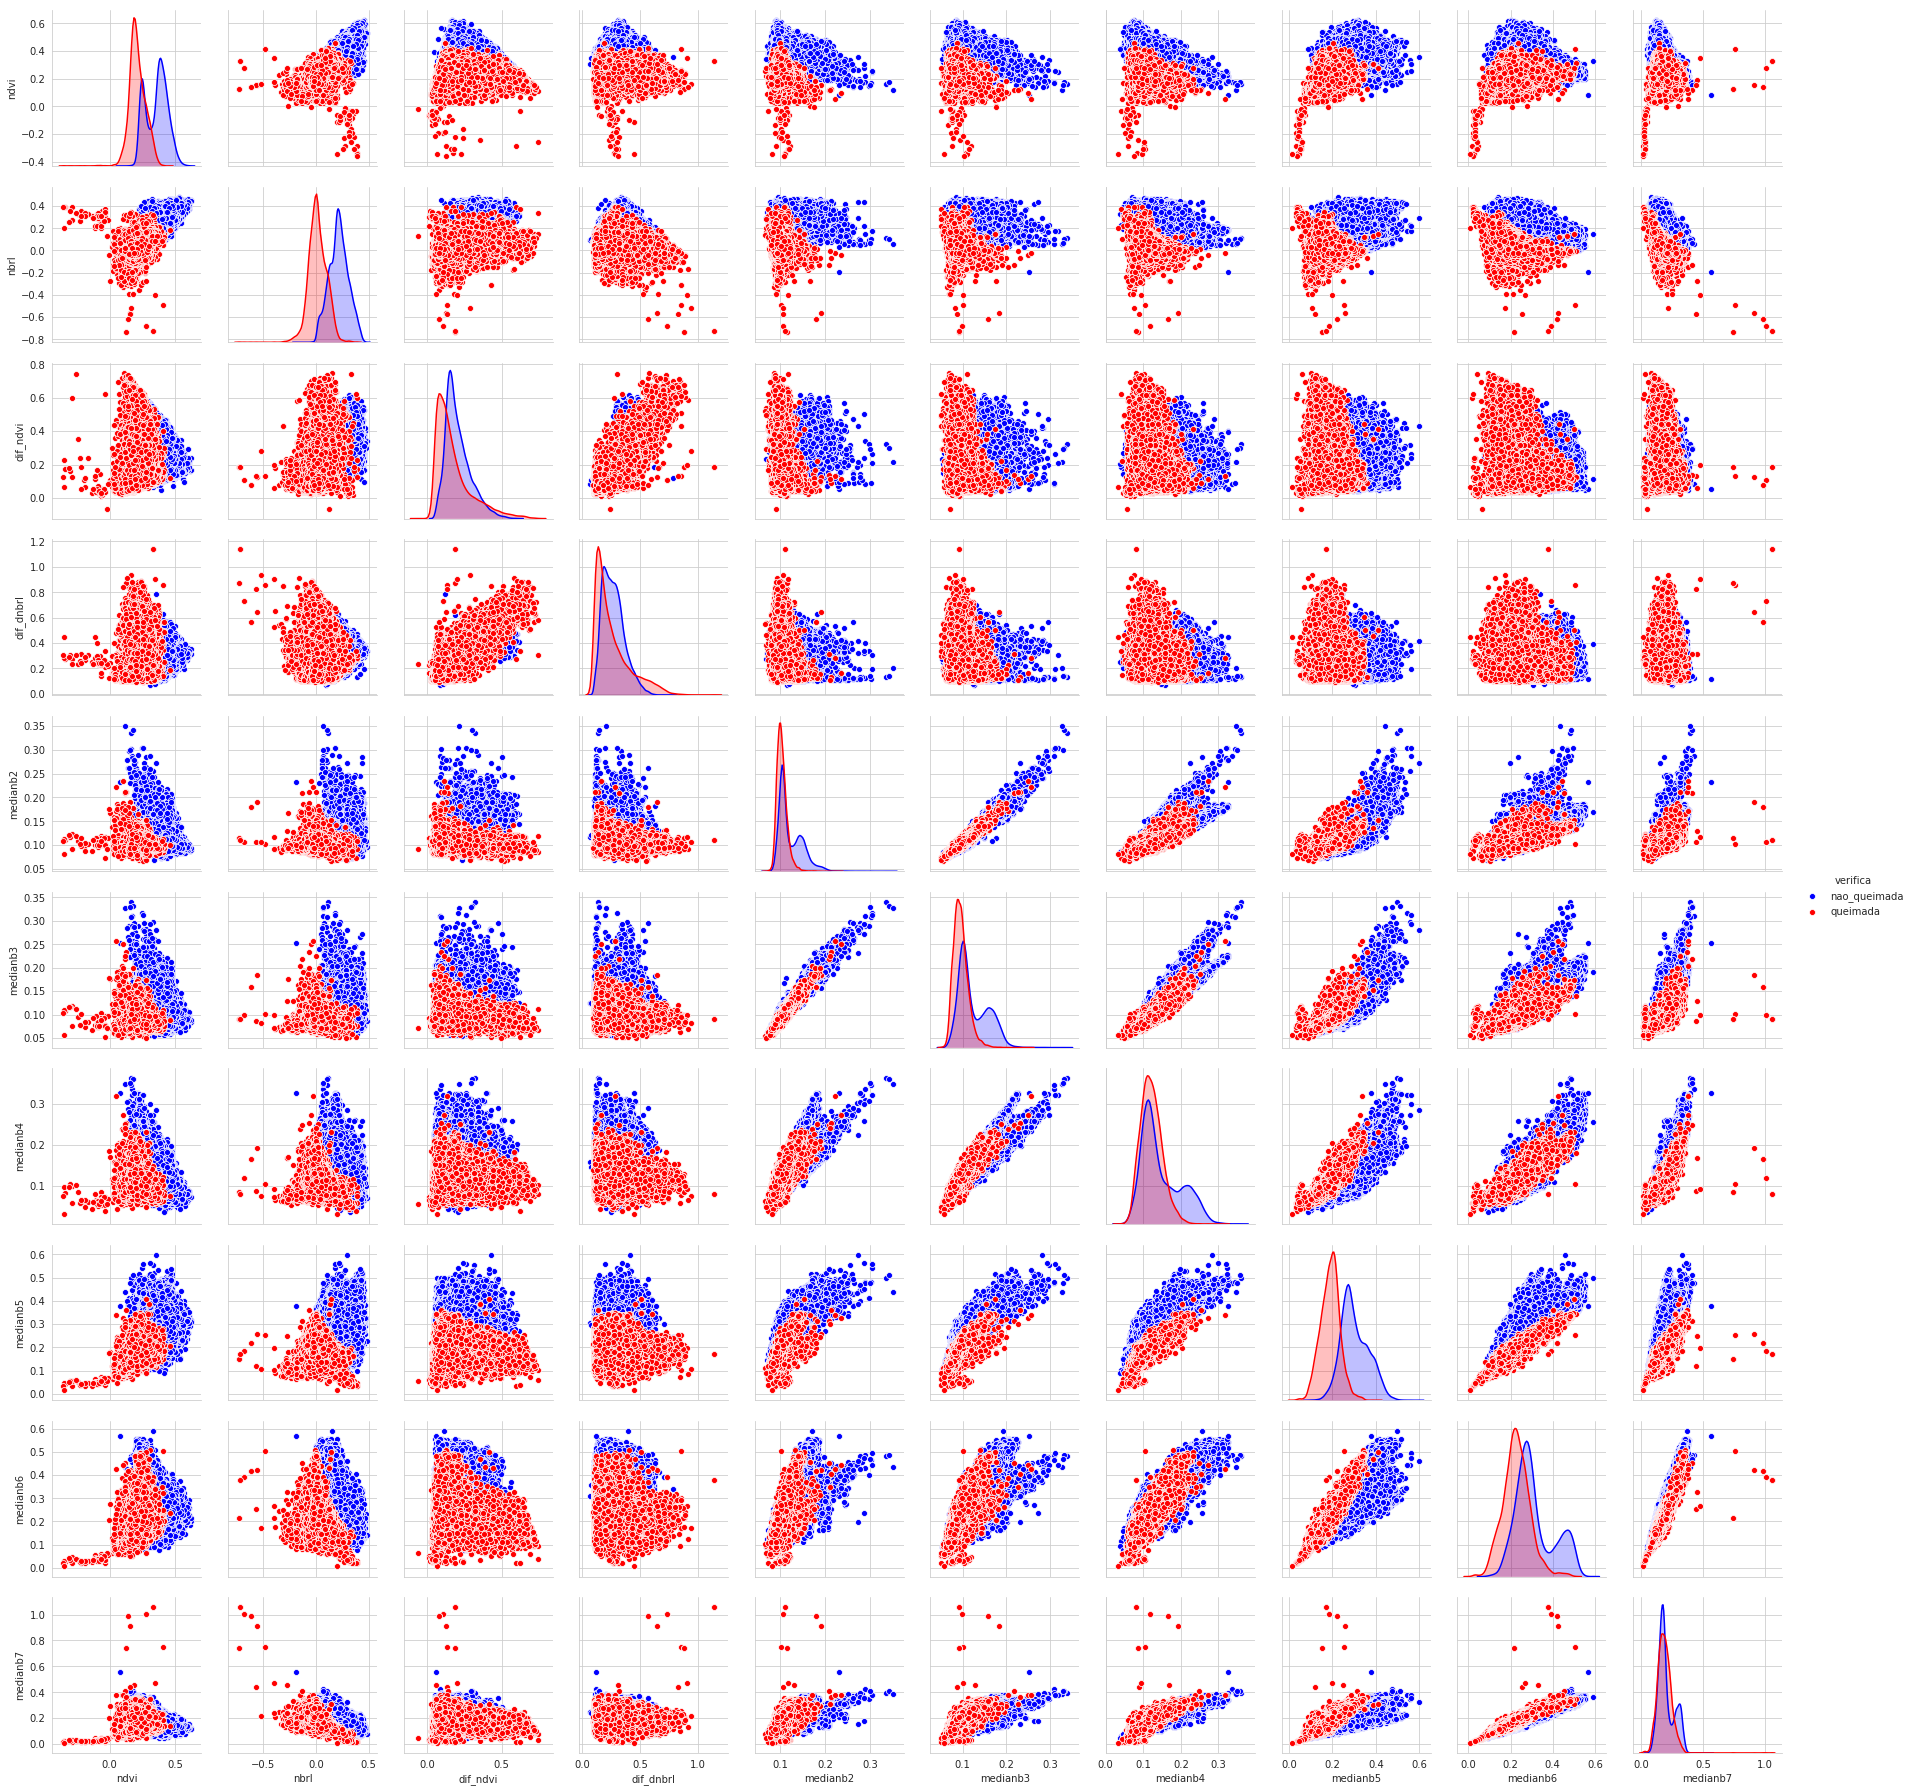

In [12]:
sns.pairplot(df_orb_pto[colunas+['verifica']], hue='verifica', palette=paleta_cores)

# Boxplot: Neste gráfico, tem 50% dos dados na parte colorida, e 25%+- nas extremidades. Os pontos mais externos são considerados outliers

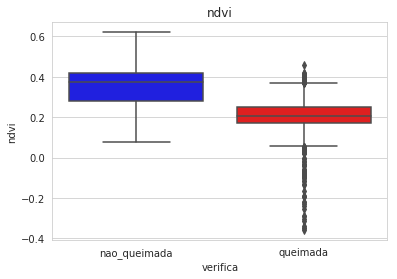

In [13]:
plt.title('ndvi')
sns.boxplot(data=df_orb_pto,x='verifica', y='ndvi', palette=paleta_cores)

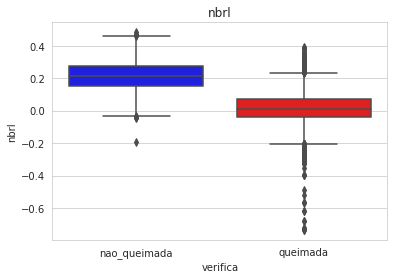

In [14]:
plt.title('nbrl')
sns.boxplot(data=df_orb_pto,x='verifica', y='nbrl', palette=paleta_cores)

# Regressão linear

/home/cicero/anaconda3/envs/aqml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


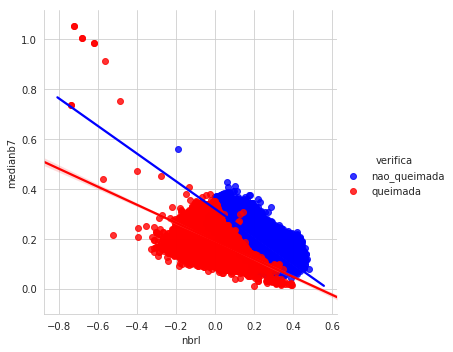

In [15]:
sns.lmplot(x='nbrl', y='medianb7', data=df_orb_pto, hue='verifica', palette=paleta_cores)

/home/cicero/anaconda3/envs/aqml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


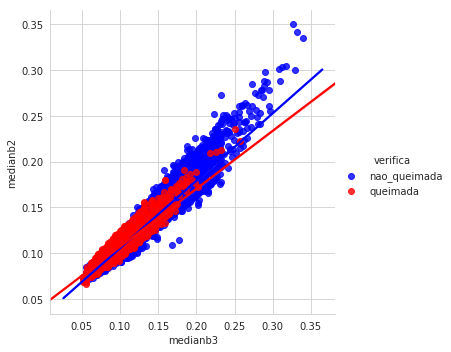

In [16]:
sns.lmplot(x='medianb3', y='medianb2', data=df_orb_pto, hue='verifica', palette=paleta_cores)

# Seleciona a passagem para ser classificada

In [17]:
id_cena = 'LS82210742017237'

# Dado(DataFrame) que será classificado

In [18]:
teste = df_orb_pto[df_orb_pto.id_cena==id_cena].copy().reset_index(drop=True)

### Distribuição dos dados em queimada e nao_queimada do teste

In [19]:
print(teste.verifica.value_counts())

nao_queimada    2367
queimada        1629
Name: verifica, dtype: int64


### Histograma NDVI do dado de teste

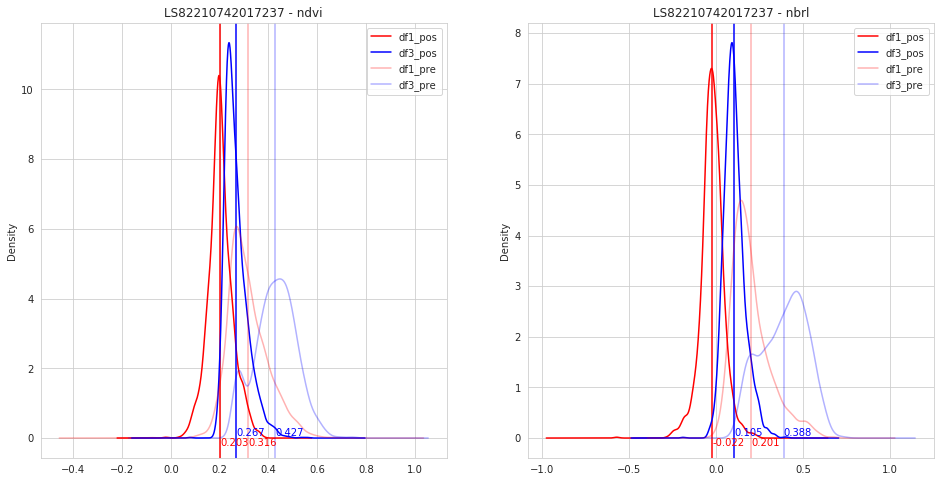

In [20]:
fig, ax = plt.subplots(figsize=(16,8))
d = teste.copy()
i = id_cena
d1 = d[d.verifica=='queimada']
d3 = d[d.verifica=='nao_queimada']

col = 'ndvi'
plt.subplot(1, 2, 1)
plt.title('%s - %s' % (i, col))
ax = d1[col].plot.kde(c='r', label='df1_pos')
plt.axvline(d1[col].mean(), c='r')
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3_pos')
plt.axvline(d3[col].mean(), c='b')
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
plt.legend()

col = 'ndvi_pre'
d1[col].plot.kde(c='r', label='df1_pre', alpha=0.3)
plt.axvline(d1[col].mean(), c='r', alpha=0.3)
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3_pre', alpha=0.3)
plt.axvline(d3[col].mean(), c='b', alpha=0.3)
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
plt.legend()

col = 'nbrl'
plt.subplot(1, 2, 2)
plt.title('%s - %s' % (i, col))
ax = d1[col].plot.kde(c='r', label='df1_pos')
plt.axvline(d1[col].mean(), c='r')
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3_pos')
plt.axvline(d3[col].mean(), c='b')
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')

col = 'nbrl_pre'
d1[col].plot.kde(c='r', label='df1_pre', alpha=0.3)
plt.axvline(d1[col].mean(), c='r', alpha=0.3)
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3_pre', alpha=0.3)
plt.axvline(d3[col].mean(), c='b', alpha=0.3)
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
plt.legend()

### 1º Teste: modelo com todas colunas e dados do ano inteiro da orb_pto

In [21]:
modelo = df_orb_pto[df_orb_pto['id_cena'] != id_cena]

### Distribuição dos dados em queimada e nao_queimada do modelo

In [22]:
print(modelo.verifica.value_counts())

nao_queimada    43442
queimada        16858
Name: verifica, dtype: int64


### Verifica se o id_cena escolhido esta no modelo de conhecimento

In [23]:
print(len(modelo[modelo.id_cena==id_cena]))

0


### Histograma NDVI do modelo de conhecimento

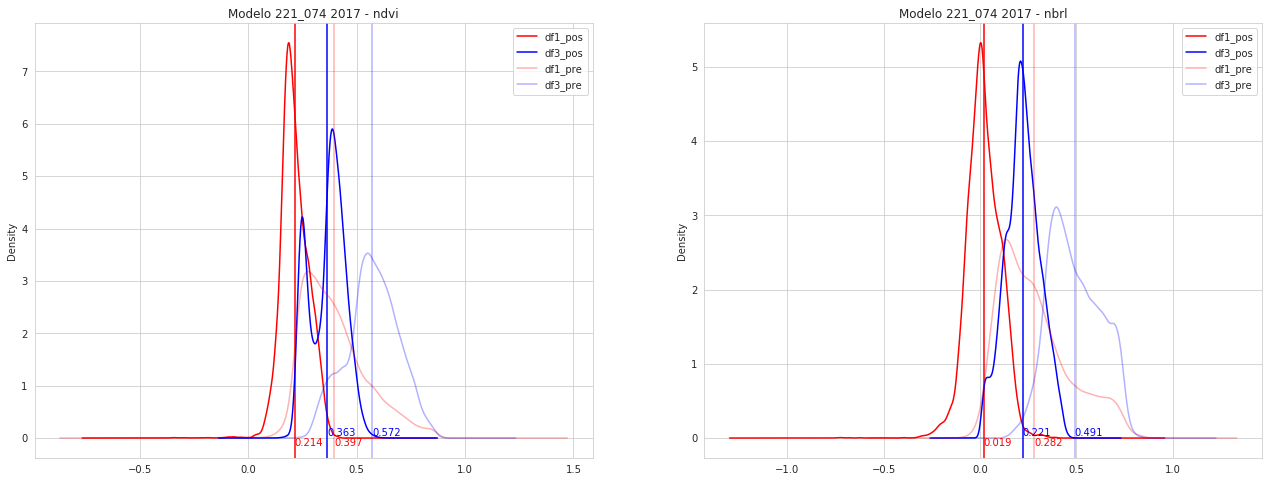

In [24]:
fig, ax = plt.subplots(figsize=(22,8))
i = 'Modelo %s %s' % (orb_pto, id_cena[-7:-3])
d = modelo.copy()
d1 = d[d.verifica=='queimada']
d3 = d[d.verifica=='nao_queimada']

col = 'ndvi'
plt.subplot(1, 2, 1)
plt.title('%s - %s' % (i, col))
ax = d1[col].plot.kde(c='r', label='df1_pos')
plt.axvline(d1[col].mean(), c='r')
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3_pos')
plt.axvline(d3[col].mean(), c='b')
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')

col = 'ndvi_pre'
d1[col].plot.kde(c='r', label='df1_pre', alpha=0.3)
plt.axvline(d1[col].mean(), c='r', alpha=0.3)
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3_pre', alpha=0.3)
plt.axvline(d3[col].mean(), c='b', alpha=0.3)
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
plt.legend()

col = 'nbrl'
plt.subplot(1, 2, 2)
plt.title('%s - %s' % (i, col))
ax = d1[col].plot.kde(c='r', label='df1_pos')
plt.axvline(d1[col].mean(), c='r')
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3_pos')
plt.axvline(d3[col].mean(), c='b')
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')

col = 'nbrl_pre'
d1[col].plot.kde(c='r', label='df1_pre', alpha=0.3)
plt.axvline(d1[col].mean(), c='r', alpha=0.3)
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3_pre', alpha=0.3)
plt.axvline(d3[col].mean(), c='b', alpha=0.3)
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
plt.legend()

## Cria classificador com Random Forest

In [25]:
classificador = RandomForestClassifier(n_jobs=8, n_estimators=100, max_features=len(colunas), random_state=0, max_depth=3, min_samples_split=5)
classificador.fit(modelo[colunas], modelo.verifica)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=8,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## Coeficiente GINI
GINI é um indice para definir a desigualdade, criado por um italiano estatistico, variando o valor de 0 a 1, onde:


    - Próximo de 0: Igualdade
    - Próximo de 1: Desigualdade

Para diferenciar dado de AREA_QUEIMADA e de NAO_AREA_QUEIMADA, é mais importante que ocorra a DESIGUALDADE, para que possa ter diferença significativa entre si dentro do mesmo conjunto de dado.

In [26]:
rank = pd.DataFrame(sorted(list(zip(colunas,classificador.feature_importances_)), key=lambda x: x[1], reverse=True), columns=['coluna', 'gini'])
rank

,coluna,gini
0,nbrl,0.673988
1,medianb5,0.325048
2,ndvi,0.000963
3,dif_ndvi,0.000000
4,dif_dnbrl,0.000000
5,medianb2,0.000000
6,medianb3,0.000000
7,medianb4,0.000000
8,medianb6,0.000000
9,medianb7,0.000000


### Classifica os dados

In [27]:
teste['rf'] = classificador.predict(teste[colunas])

### Cria funcao para ver o resultado somente de QUEIMADA

In [28]:
class_names = ['nao_queimada','queimada']

def ver_resultado(dado, coluna_previsao, coluna_verdade):
    queimada = 'queimada'
    nao_queimada = 'nao_queimada'
    try:
        d1 = dado[dado[coluna_verdade]==queimada]
        d2 = dado[dado[coluna_verdade]==nao_queimada]
        d3 = dado[(dado[coluna_previsao]==queimada) & (dado[coluna_verdade]==nao_queimada)]
        d4 = dado[(dado[coluna_previsao]==nao_queimada) & (dado[coluna_verdade]==queimada)]

        ax = d1.plot(kind='scatter', x='ndvi', y='nbrl', c='r', figsize=(22,8), label='verdade 1(%s)' % len(d1))
        d2.plot(kind='scatter', x='ndvi', y='nbrl', c='b', ax=ax, label='verdade 3(%s)' % len(d2))
        if len(d3):
            d3.plot(kind='scatter', x='ndvi', y='nbrl', c='r', ax=ax, marker='o', label='erro previsão de 3(%s)' % len(d3), s=50, facecolors='none', edgecolors='b')
        if len(d4):
            d4.plot(kind='scatter', x='ndvi', y='nbrl', c='b', ax=ax, marker='o', label='erro previsão de 1(%s)' % len(d4), s=50, facecolors='none', edgecolors='r')
        plt.legend()
        
        df = dado.sort_values('id').reset_index(drop=True)
        mostra_resultado(df[coluna_verdade], df[coluna_previsao])
    except Exception as e:
        print(e)
        return e
def mostra_resultado(y_true, y_pred):
    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Quantitativo')

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Porcentagem')

    plt.show()
    total_acertos = accuracy_score(y_true, y_pred, normalize=False)
    porcentagem_acertos = int(accuracy_score(y_true, y_pred)*100)
    print('Acertos: %s/%s (%s%%)' % (total_acertos, len(y_pred), porcentagem_acertos) )

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Greens):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

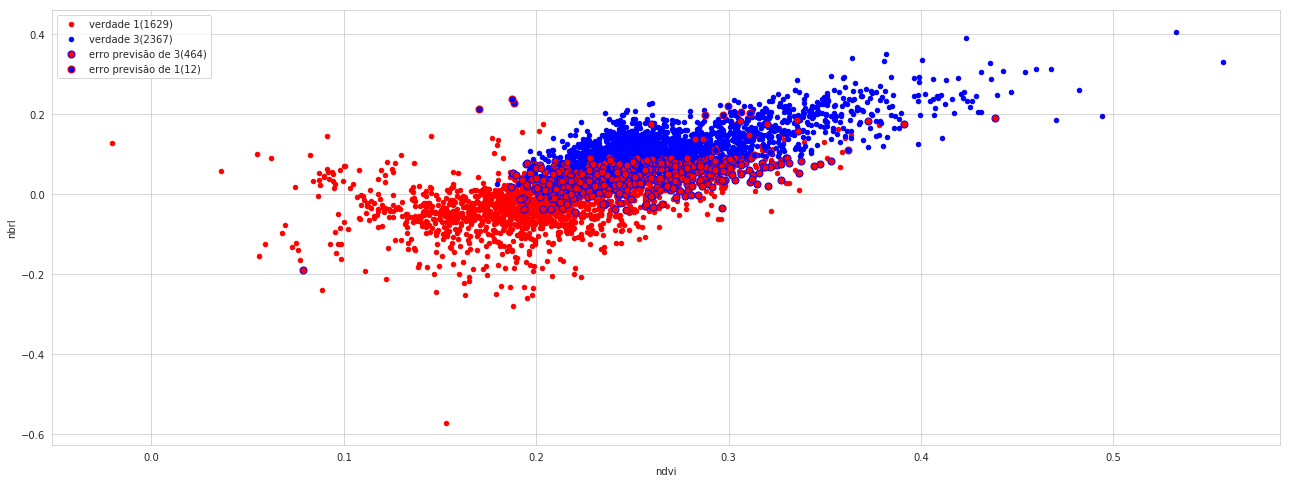

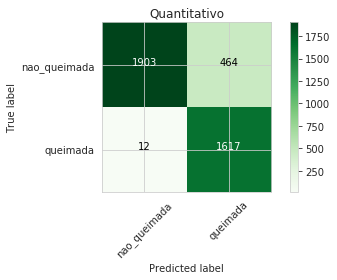

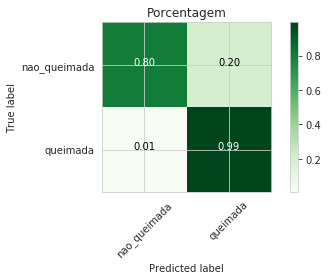

Acertos: 3520/3996 (88%)


In [29]:
ver_resultado(teste, 'rf', 'verifica')

### 2º Teste: modelo com dados de todos os anos da mesma orb_pto e todas colunas

In [30]:
modelo = df[df.orb_pto==orb_pto].copy()

In [31]:
print(modelo.verifica.value_counts())

nao_queimada    141857
queimada         58916
Name: verifica, dtype: int64


### Anos no modelo

In [32]:
anos = sorted(modelo.id_cena.str[-7:-3].unique())
anos

['2016', '2017', '2018']

Text(0.500633,0,'0.501')

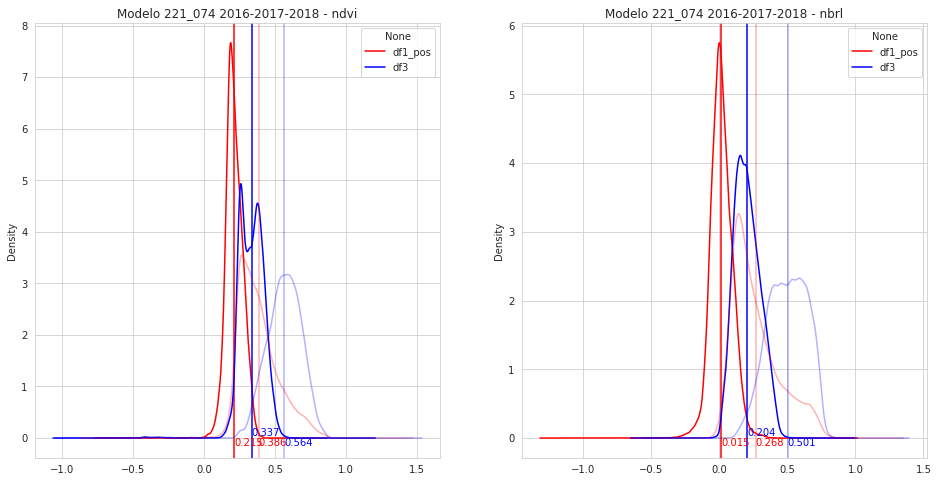

In [33]:
fig, ax = plt.subplots(figsize=(16,8))
d = modelo.copy()
i = 'Modelo %s %s' % (orb_pto, "-".join(map(str, anos)))
d1 = d[d.verifica=='queimada']
d3 = d[d.verifica=='nao_queimada']

col = 'ndvi'
plt.subplot(1, 2, 1)
plt.title('%s - %s' % (i, col))
ax = d1[col].plot.kde(c='r', label='df1_pos')
plt.axvline(d1[col].mean(), c='r')
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3')
plt.axvline(d3[col].mean(), c='b')
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
plt.legend()

col = 'ndvi_pre'
d1[col].plot.kde(c='r', label='df1_pre', alpha=0.3)
plt.axvline(d1[col].mean(), c='r', alpha=0.3)
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3_pre', alpha=0.3)
plt.axvline(d3[col].mean(), c='b', alpha=0.3)
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='top')

col = 'nbrl'
plt.subplot(1, 2, 2)
plt.title('%s - %s' % (i, col))
ax = d1[col].plot.kde(c='r', label='df1_pos')
plt.axvline(d1[col].mean(), c='r')
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3')
plt.axvline(d3[col].mean(), c='b')
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
plt.legend()

col = 'nbrl_pre'
d1[col].plot.kde(c='r', label='df1_pre', alpha=0.3)
plt.axvline(d1[col].mean(), c='r', alpha=0.3)
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3_pre', alpha=0.3)
plt.axvline(d3[col].mean(), c='b', alpha=0.3)
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='top')

In [34]:
classificador = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_features=len(colunas), random_state=0, max_depth=3, min_samples_split=5)
classificador.fit(modelo[colunas], modelo.verifica)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [35]:
rank = pd.DataFrame(sorted(list(zip(colunas,classificador.feature_importances_)), key=lambda x: x[1], reverse=True), columns=['coluna', 'gini'])
rank

,coluna,gini
0,nbrl,0.752631
1,medianb5,0.245468
2,medianb6,0.001902
3,ndvi,0.000000
4,dif_ndvi,0.000000
5,dif_dnbrl,0.000000
6,medianb2,0.000000
7,medianb3,0.000000
8,medianb4,0.000000
9,medianb7,0.000000


In [36]:
teste['rf'] = classificador.predict(teste[colunas])

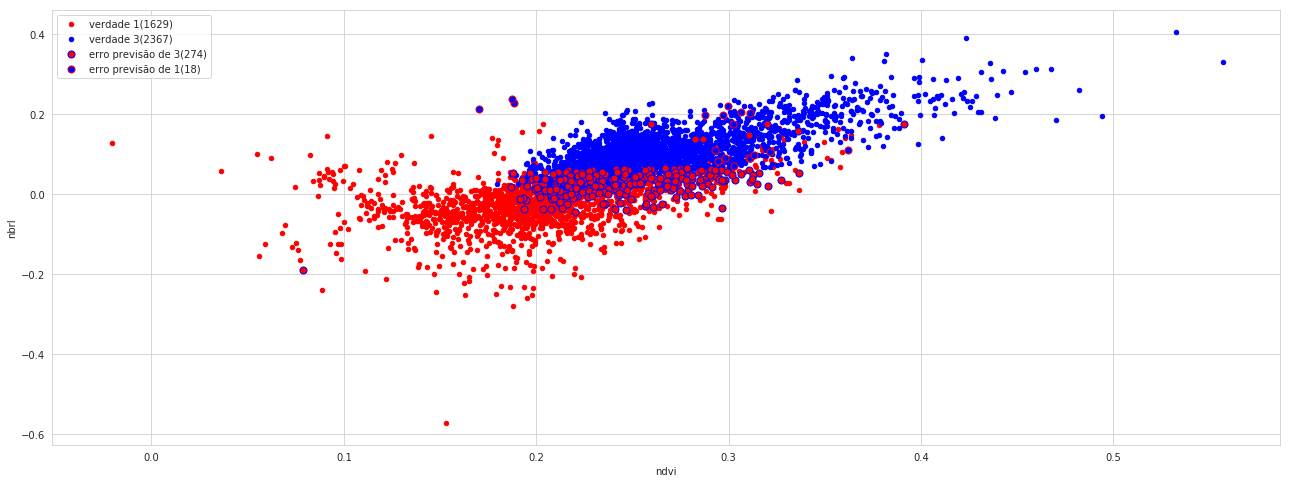

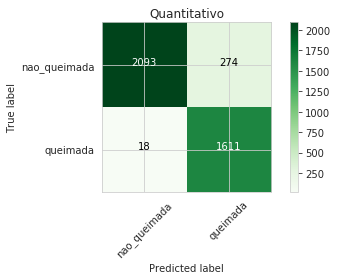

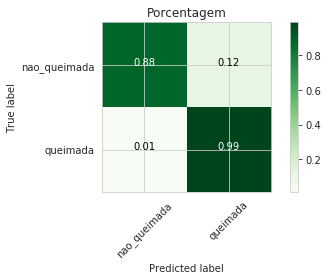

Acertos: 3704/3996 (92%)


In [37]:
ver_resultado(teste, 'rf', 'verifica')

### 3º Teste: modelo dados do trimestre da mesma orb_pto e todas colunas

In [38]:
modelo['dia'] = modelo.id_cena.str[-3:].astype(int)
dia = int(id_cena[-3:])

modelo = modelo[modelo.dia.isin(range(dia-90, dia+90))].copy()

In [39]:
print(modelo.verifica.value_counts())

nao_queimada    104409
queimada         35635
Name: verifica, dtype: int64


## Anos no modelo

In [40]:
anos = sorted(modelo.id_cena.str[-7:-3].unique())
anos

['2016', '2017']

Text(0.468212,0,'0.468')

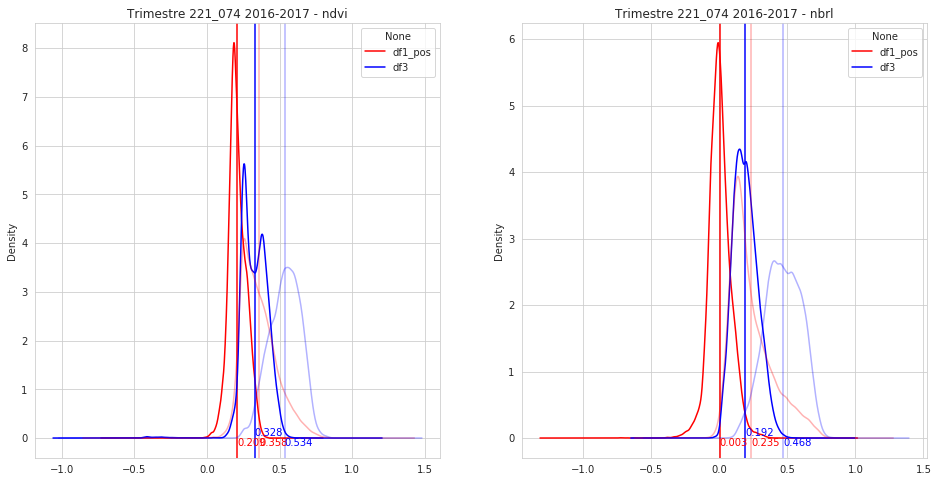

In [41]:
fig, ax = plt.subplots(figsize=(16,8))
d = modelo.copy()
i = 'Trimestre %s %s' % (orb_pto, "-".join(map(str, anos)))
d1 = d[d.verifica=='queimada']
d3 = d[d.verifica=='nao_queimada']

col = 'ndvi'
plt.subplot(1, 2, 1)
plt.title('%s - %s' % (i, col))
ax = d1[col].plot.kde(c='r', label='df1_pos')
plt.axvline(d1[col].mean(), c='r')
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3')
plt.axvline(d3[col].mean(), c='b')
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
plt.legend()

col = 'ndvi_pre'
d1[col].plot.kde(c='r', label='df1_pre', alpha=0.3)
plt.axvline(d1[col].mean(), c='r', alpha=0.3)
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3_pre', alpha=0.3)
plt.axvline(d3[col].mean(), c='b', alpha=0.3)
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='top')

col = 'nbrl'
plt.subplot(1, 2, 2)
plt.title('%s - %s' % (i, col))
ax = d1[col].plot.kde(c='r', label='df1_pos')
plt.axvline(d1[col].mean(), c='r')
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3')
plt.axvline(d3[col].mean(), c='b')
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
plt.legend()

col = 'nbrl_pre'
d1[col].plot.kde(c='r', label='df1_pre', alpha=0.3)
plt.axvline(d1[col].mean(), c='r', alpha=0.3)
ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')

d3[col].plot.kde(c='b', label='df3_pre', alpha=0.3)
plt.axvline(d3[col].mean(), c='b', alpha=0.3)
ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='top')

In [42]:
classificador = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_features=len(colunas), random_state=0, max_depth=3, min_samples_split=5)
classificador.fit(modelo[colunas], modelo.verifica)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [43]:
rank = pd.DataFrame(sorted(list(zip(colunas,classificador.feature_importances_)), key=lambda x: x[1], reverse=True), columns=['coluna', 'gini'])
rank

,coluna,gini
0,nbrl,0.784647
1,medianb5,0.151390
2,medianb6,0.062981
3,medianb3,0.000929
4,medianb2,0.000052
5,ndvi,0.000000
6,dif_ndvi,0.000000
7,dif_dnbrl,0.000000
8,medianb4,0.000000
9,medianb7,0.000000


In [44]:
teste['rf'] = classificador.predict(teste[colunas])

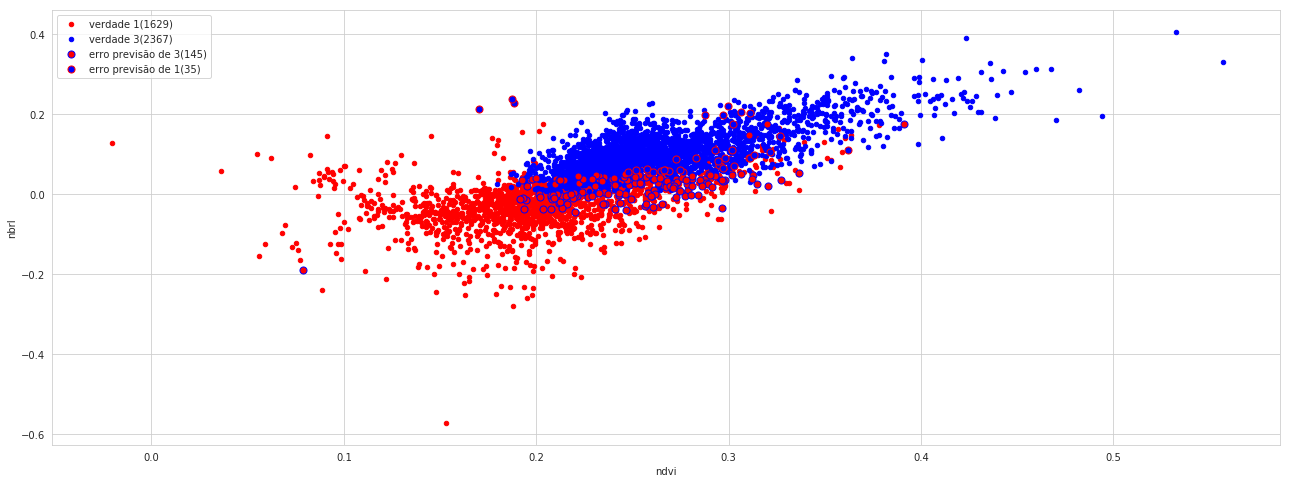

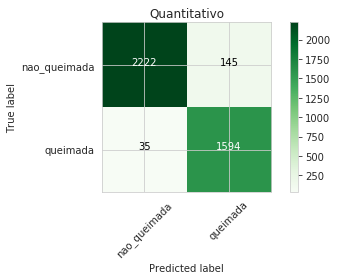

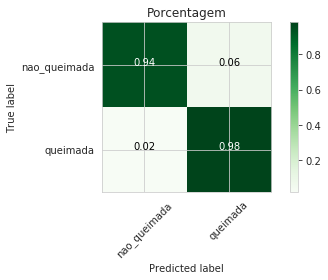

Acertos: 3816/3996 (95%)


In [45]:
ver_resultado(teste, 'rf', 'verifica')

### 4º Teste: modelo dados do trimestre da mesma orb_pto e todas colunas - Aumenta número de arvores

In [46]:
classificador = RandomForestClassifier(n_jobs=-1, n_estimators=1000, max_features=len(colunas), random_state=0, max_depth=3, min_samples_split=5)
classificador.fit(modelo[colunas], modelo.verifica)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [47]:
rank = pd.DataFrame(sorted(list(zip(colunas,classificador.feature_importances_)), key=lambda x: x[1], reverse=True), columns=['coluna', 'gini'])
rank

,coluna,gini
0,nbrl,0.784120
1,medianb5,0.153044
2,medianb6,0.061779
3,medianb3,0.001046
4,medianb2,0.000011
5,ndvi,0.000000
6,dif_ndvi,0.000000
7,dif_dnbrl,0.000000
8,medianb4,0.000000
9,medianb7,0.000000


In [48]:
teste['rf'] = classificador.predict(teste[colunas])

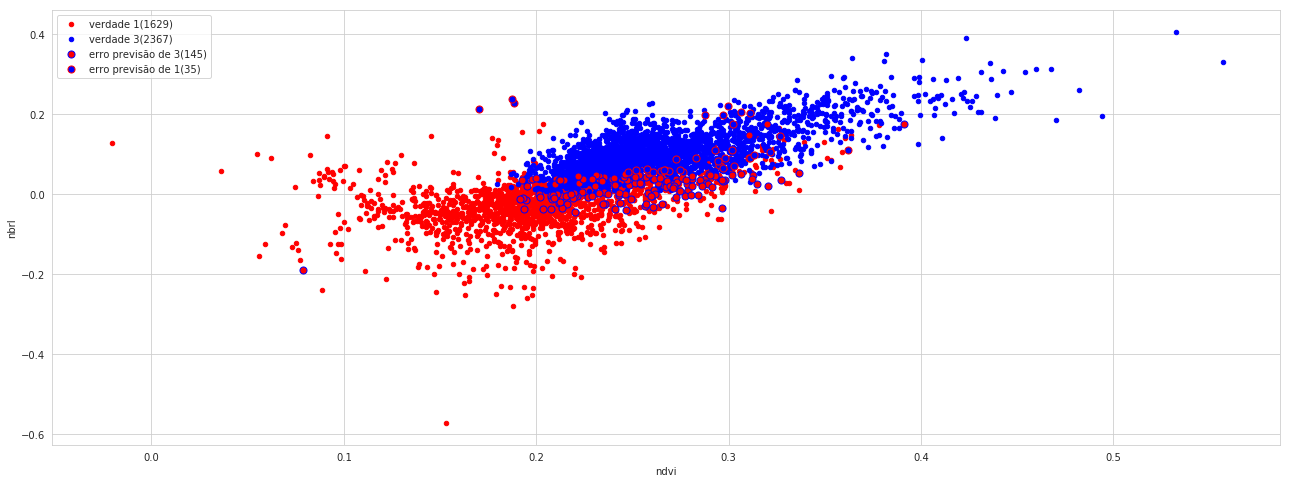

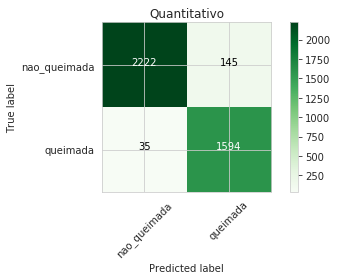

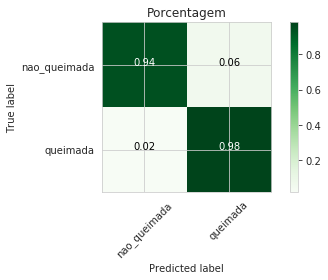

Acertos: 3816/3996 (95%)


In [49]:
ver_resultado(teste, 'rf', 'verifica')

### 5º Teste: modelo dados do trimestre da mesma orb_pto e todas colunas - diminui número de arvores

In [50]:
classificador = RandomForestClassifier(n_jobs=-1, n_estimators=2, max_features=len(colunas), random_state=0, max_depth=3, min_samples_split=5)
classificador.fit(modelo[colunas], modelo.verifica)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [51]:
rank = pd.DataFrame(sorted(list(zip(colunas,classificador.feature_importances_)), key=lambda x: x[1], reverse=True), columns=['coluna', 'gini'])
rank

,coluna,gini
0,nbrl,0.786146
1,medianb5,0.178689
2,medianb6,0.035165
3,ndvi,0.000000
4,dif_ndvi,0.000000
5,dif_dnbrl,0.000000
6,medianb2,0.000000
7,medianb3,0.000000
8,medianb4,0.000000
9,medianb7,0.000000


In [52]:
teste['rf'] = classificador.predict(teste[colunas])

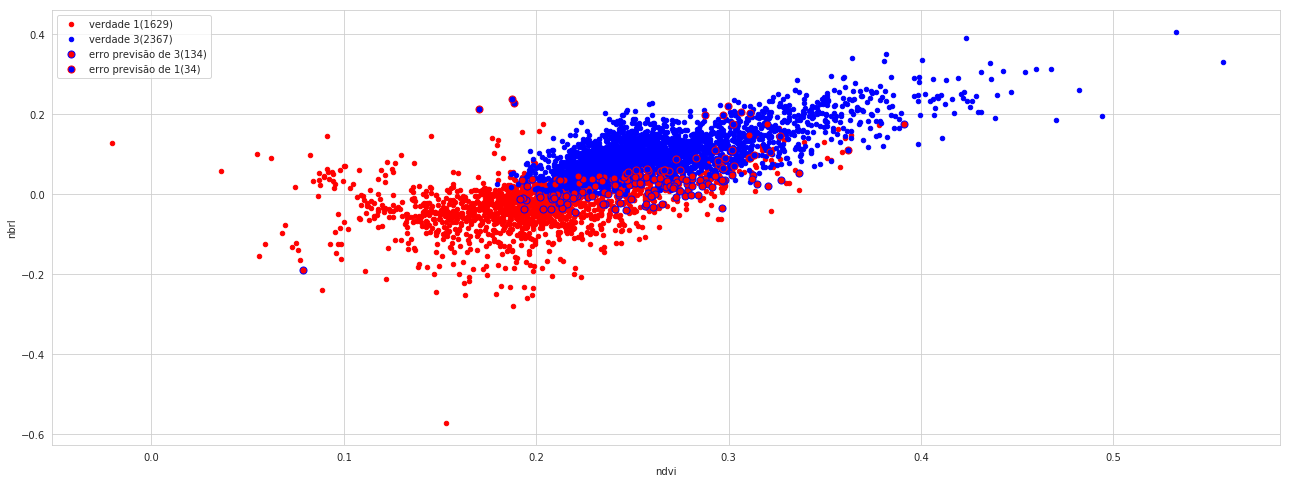

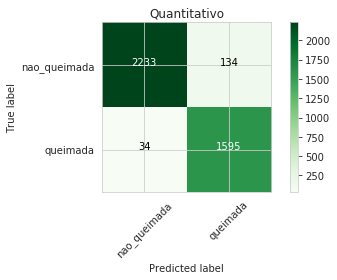

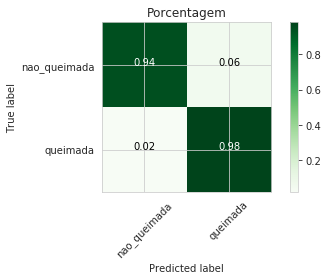

Acertos: 3828/3996 (95%)


In [53]:
ver_resultado(teste, 'rf', 'verifica')

### 6º Teste: modelo dados do trimestre da mesma orb_pto e 2 colunas: nbrl e medianb5

In [62]:
colunas = ['nbrl', 'medianb5']
classificador = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_features=len(colunas), random_state=0, max_depth=3, min_samples_split=5)
classificador.fit(modelo[colunas], modelo.verifica)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [63]:
rank = pd.DataFrame(sorted(list(zip(colunas,classificador.feature_importances_)), key=lambda x: x[1], reverse=True), columns=['coluna', 'gini'])
rank

,coluna,gini
0,nbrl,0.780587
1,medianb5,0.219413


In [64]:
teste['rf'] = classificador.predict(teste[colunas])

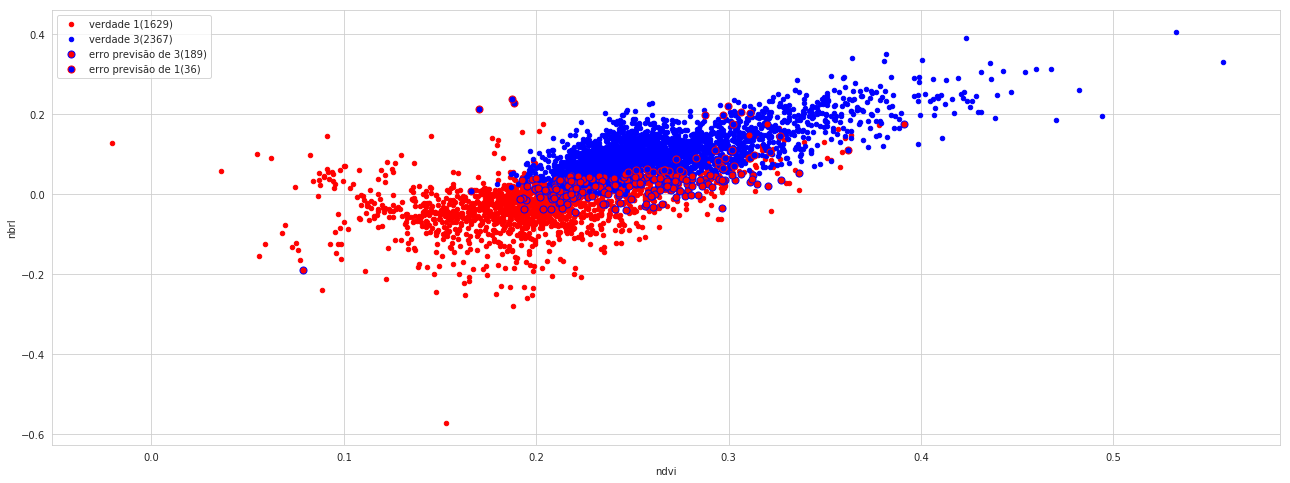

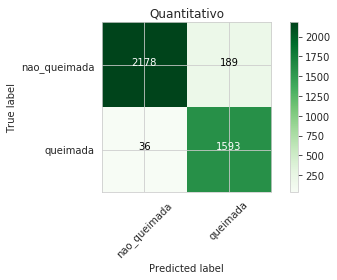

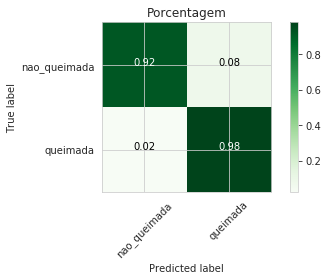

Acertos: 3771/3996 (94%)


In [65]:
ver_resultado(teste, 'rf', 'verifica')

### 7º Teste: modelo dados do trimestre da mesma orb_pto e 2 colunas: medianb3 e medianb2

In [66]:
colunas = ['medianb3', 'medianb2']
classificador = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_features=len(colunas), random_state=0, max_depth=3, min_samples_split=5)
classificador.fit(modelo[colunas], modelo.verifica)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [67]:
rank = pd.DataFrame(sorted(list(zip(colunas,classificador.feature_importances_)), key=lambda x: x[1], reverse=True), columns=['coluna', 'gini'])
rank

,coluna,gini
0,medianb2,0.809235
1,medianb3,0.190765


In [68]:
teste['rf'] = classificador.predict(teste[colunas])

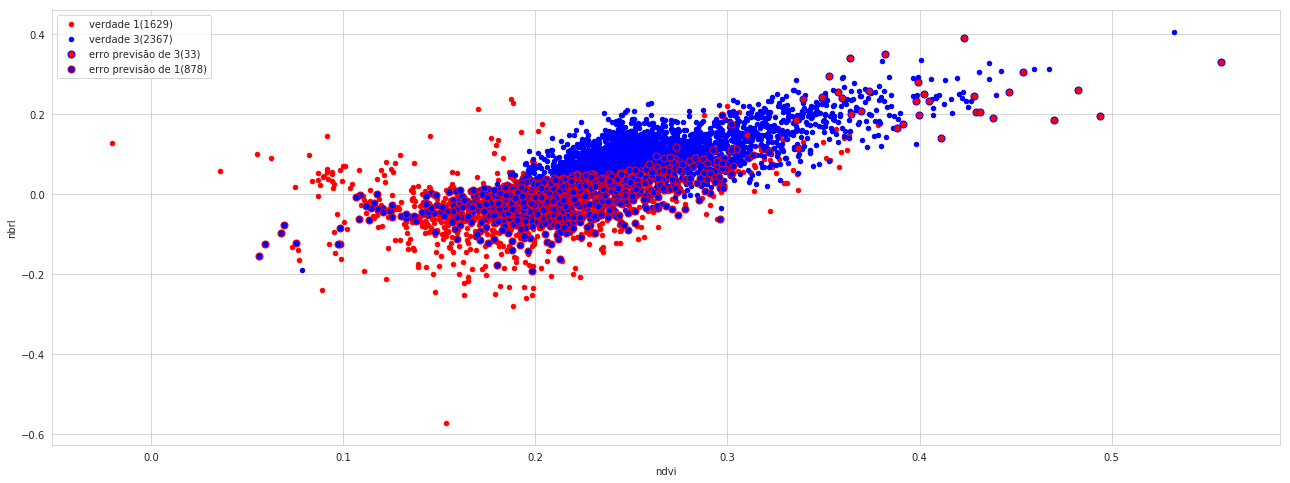

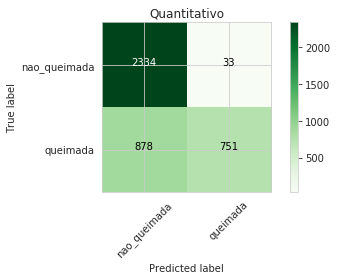

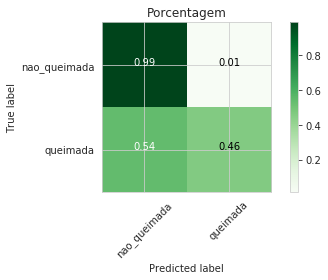

Acertos: 3085/3996 (77%)


In [69]:
ver_resultado(teste, 'rf', 'verifica')

### 8º Teste: modelo dados de todos anos da mesma orb_pto e 2 colunas: nbrl e medianb5

In [70]:
colunas = ['nbrl', 'medianb5']
classificador = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_features=len(colunas), random_state=0, max_depth=3, min_samples_split=5)
classificador.fit(modelo[colunas], modelo.verifica)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [71]:
rank = pd.DataFrame(sorted(list(zip(colunas,classificador.feature_importances_)), key=lambda x: x[1], reverse=True), columns=['coluna', 'gini'])
rank

,coluna,gini
0,nbrl,0.780587
1,medianb5,0.219413


In [72]:
teste['rf'] = classificador.predict(teste[colunas])

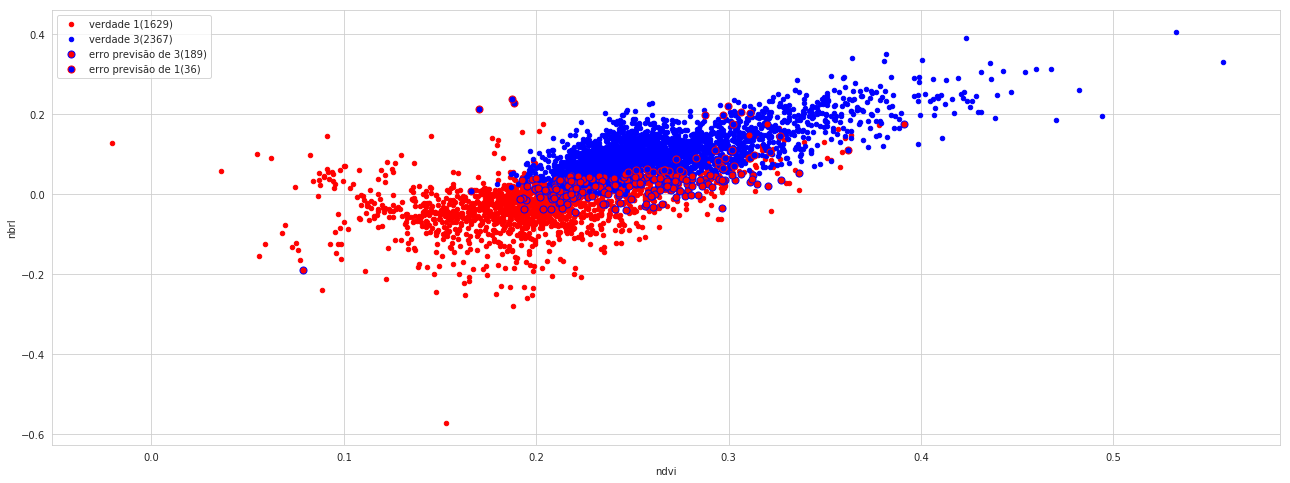

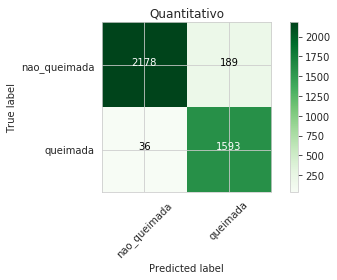

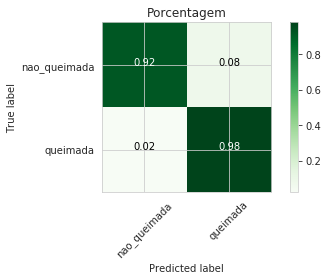

Acertos: 3771/3996 (94%)


In [73]:
ver_resultado(teste, 'rf', 'verifica')